In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from data import VideoFrameFolder

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = torchvision.transforms.functional.to_pil_image(inp)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
vid_file = 'videos/IMG_2139.MOV'

In [5]:

data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


val_dataset = VideoFrameFolder('/home/tormod/ucph-erda-home/frames/',
                              transform=data_transforms['val'])
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=30,
                                            shuffle=False,
                                            num_workers=8)

# MMPose

In [11]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

In [8]:
det_model = init_detector('mmpose_configs/faster_rcnn_r50_fpn_1x_coco.py',
                          'http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth')

/home/tormod/anaconda3/envs/apec/lib/python3.6/site-packages/mmdet/models/builder.py:72: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  'please specify them in model', UserWarning)


Use load_from_http loader


(1280, 720, 3)


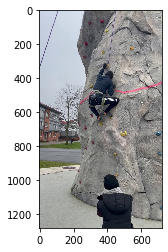

In [53]:
from PIL import Image
img = torchvision.transforms.functional.to_pil_image(val_dataset[400][0])
img = np.array(img)
print(img.shape)
plt.imshow(img)

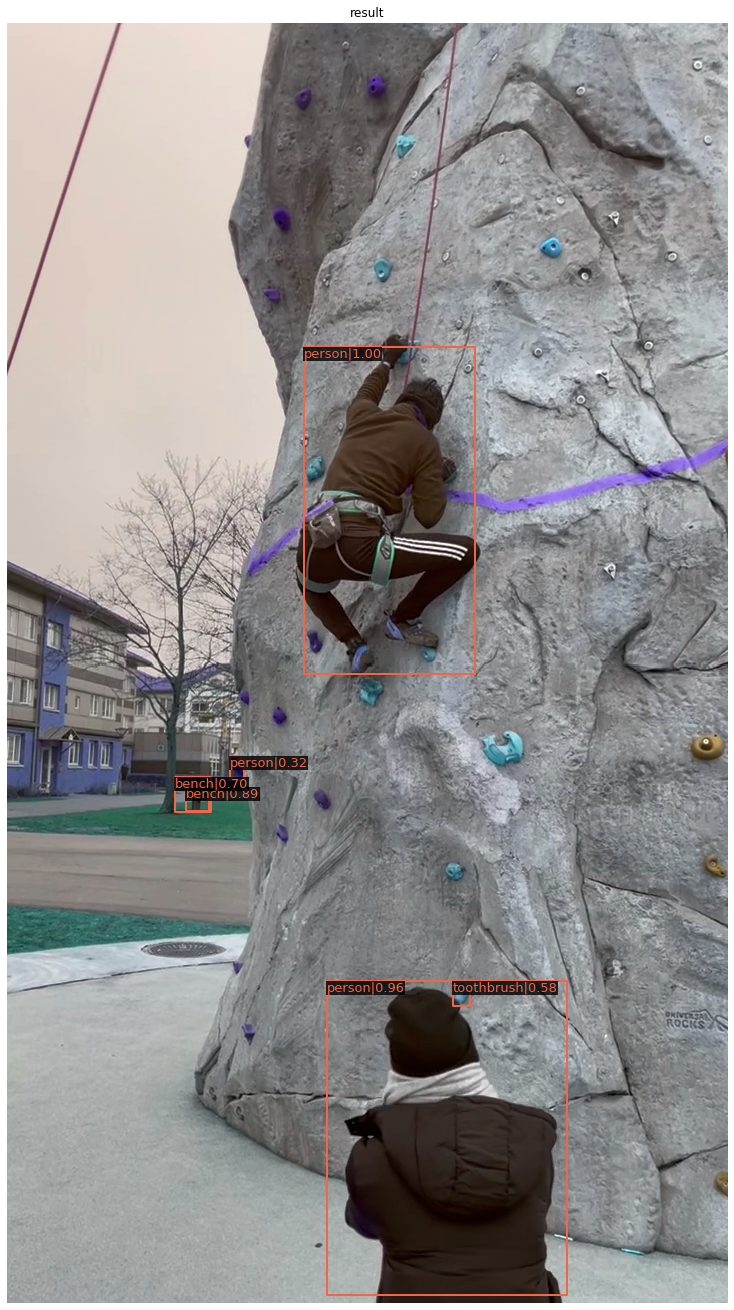

In [54]:
mmdet_results = inference_detector(det_model, img)
show_result_pyplot(det_model, img, mmdet_results)

In [6]:
from mmtrack.apis import init_model, inference_vid

In [14]:
track_model = init_model('../mmtracking/configs/vid/selsa/selsa_faster_rcnn_r50_dc5_1x_imagenetvid.py',
                         'https://download.openmmlab.com/mmtracking/vid/selsa/selsa_faster_rcnn_r50_dc5_1x_imagenetvid/selsa_faster_rcnn_r50_dc5_1x_imagenetvid_20201227_204835-2f5a4952.pth',
                        device='cpu')

Use load_from_http loader


In [26]:
for i in range(1):
    img = val_dataset[i][0]
    img = torchvision.transforms.functional.to_pil_image(img)
    #img = torchvision.transforms.functional.resize(img, (200,100))
    img = np.array(img)
    print(img.dtype)
    inference_vid(track_model, img, i)

uint8


TypeError: 'DataContainer' object does not support indexing

# Torchvision detection

In [45]:
det = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/tormod/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [62]:
val_dataset[0][0].shape

torch.Size([3, 1280, 720])

In [71]:
if 'pred' in globals():
    del pred
det.eval()
pred = det(val_dataset[0][0].unsqueeze(0))
#pred

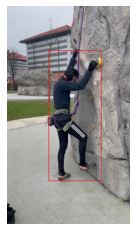

In [72]:
def draw_best_box(frames, preds):
    imgs = []
    for f, p in zip(frames, preds): 
        uint_inputframe = torchvision.transforms.functional.convert_image_dtype(f, torch.uint8)
        wboxes = torchvision.utils.draw_bounding_boxes(uint_inputframe, p['boxes'][0:1], colors=['red'], width=3)
        imgs.append(wboxes)
    return torchvision.utils.make_grid(imgs)

imshow(draw_best_box(val_dataset[0][0].unsqueeze(0), pred))